<a href="https://colab.research.google.com/github/jibbsmathew/Spotify_Data_Study/blob/main/Spotify_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install spotipy requests pandas

In [17]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

In [18]:
# Connecting to Spotify API

import requests
import base64

# Replace with your own Client ID and Client Secret
CLIENT_ID = '<your-client-id>'
CLIENT_SECRET = '<your-client-secret>'

# Base64 encode the client ID and client secret
client_credentials = f"{CLIENT_ID}:{CLIENT_SECRET}"
client_credentials_base64 = base64.b64encode(client_credentials.encode())

# Request the access token
token_url = 'https://accounts.spotify.com/api/token'
headers = {
    'Authorization': f'Basic {client_credentials_base64.decode()}'
}
data = {
    'grant_type': 'client_credentials'
}
response = requests.post(token_url, data=data, headers=headers)

if response.status_code == 200:
    access_token = response.json()['access_token']
    print("Access token obtained successfully.")
else:
    print("Error obtaining access token.")
    exit()

Access token obtained successfully.


In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_trending_playlist_data(playlist_id, access_token):
    # Set up Spotipy with the access token
    sp = spotipy.Spotify(auth=access_token)

    # Get the tracks from the playlist
    playlist_tracks = sp.playlist_tracks(playlist_id, fields='items(track(id, name, artists, album(id, name)))')

    # Extract relevant information and store in a list of dictionaries
    music_data = []
    for track_info in playlist_tracks['items']:
        track = track_info['track']
        track_name = track['name']
        artists = ', '.join([artist['name'] for artist in track['artists']])
        album_name = track['album']['name']
        album_id = track['album']['id']
        track_id = track['id']

        # Get audio features for the track
        audio_features = sp.audio_features(track_id)[0] if track_id != 'Not available' else None

        # Get release date of the album
        try:
            album_info = sp.album(album_id) if album_id != 'Not available' else None
            release_date = album_info['release_date'] if album_info else None
        except:
            release_date = None

        # Get popularity of the track
        try:
            track_info = sp.track(track_id) if track_id != 'Not available' else None
            popularity = track_info['popularity'] if track_info else None
        except:
            popularity = None

        # Add additional track information to the track data
        track_data = {
            'Track Name': track_name,
            'Artists': artists,
            'Album Name': album_name,
            'Album ID': album_id,
            'Track ID': track_id,
            'Popularity': popularity,
            'Release Date': release_date,
            'Duration (ms)': audio_features['duration_ms'] if audio_features else None,
            'Explicit': track_info.get('explicit', None),
            'External URLs': track_info.get('external_urls', {}).get('spotify', None),
            'Danceability': audio_features['danceability'] if audio_features else None,
            'Energy': audio_features['energy'] if audio_features else None,
            'Key': audio_features['key'] if audio_features else None,
            'Loudness': audio_features['loudness'] if audio_features else None,
            'Mode': audio_features['mode'] if audio_features else None,
            'Speechiness': audio_features['speechiness'] if audio_features else None,
            'Acousticness': audio_features['acousticness'] if audio_features else None,
            'Instrumentalness': audio_features['instrumentalness'] if audio_features else None,
            'Liveness': audio_features['liveness'] if audio_features else None,
            'Valence': audio_features['valence'] if audio_features else None,
            'Tempo': audio_features['tempo'] if audio_features else None,
            # Add more attributes as needed
        }

        music_data.append(track_data)

    # Create a pandas DataFrame from the list of dictionaries
    df = pd.DataFrame(music_data)

    return df

In [20]:
#Consider playlistID: https://open.spotify.com/playlist/4exbnYbqqeM7sajzY4d8ff?si=44cc745a483341a9
#Playlist ID: anything after '/playlist/' and before '?' : 4exbnYbqqeM7sajzY4d8ff

playlist_id = '0OsESTG5UFHYYJi7sfdto0'

# Call the function to get the music data from the playlist and store it in a DataFrame
music_df = get_trending_playlist_data(playlist_id, access_token)

# Display the DataFrame
print(music_df)

                                    Track Name                  Artists  \
0                                      The Pot                     TOOL   
1             Eye of the Beholder (Remastered)                Metallica   
2                                Thunderstruck                    AC/DC   
3                                       I Wish            Stevie Wonder   
4                            Land of Confusion                Disturbed   
..                                         ...                      ...   
95  She's Got the Rhythm (And I Got the Blues)             Alan Jackson   
96                                    Mz. Hyde                Halestorm   
97                                 Magic Touch                Aerosmith   
98                            A Little Bit Off  Five Finger Death Punch   
99                                        Swim                     Bush   

                                           Album Name                Album ID  \
0                 

In [21]:
#Check null values
print(music_df.isnull().sum())

Track Name          0
Artists             0
Album Name          0
Album ID            0
Track ID            0
Popularity          0
Release Date        0
Duration (ms)       0
Explicit            0
External URLs       0
Danceability        0
Energy              0
Key                 0
Loudness            0
Mode                0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
dtype: int64


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

data = music_df

In [23]:
# Function to calculate weighted popularity scores based on release date
def calculate_weighted_popularity(release_date):
    # Convert the release date to datetime object
    release_date = datetime.strptime(release_date, '%Y-%m-%d')

    # Calculate the time span between release date and today's date
    time_span = datetime.now() - release_date

    # Calculate the weighted popularity score based on time span (e.g., more recent releases have higher weight)
    weight = 1 / (time_span.days + 1)
    return weight

In [24]:
# Normalize the music features using Min-Max scaling
scaler = MinMaxScaler()
music_features = music_df[['Danceability', 'Energy', 'Key',
                           'Loudness', 'Mode', 'Speechiness', 'Acousticness',
                           'Instrumentalness', 'Liveness', 'Valence', 'Tempo']].values
music_features_scaled = scaler.fit_transform(music_features)

In [25]:
# a function to get content-based recommendations based on music features
def content_based_recommendations(input_song_name, num_recommendations=5):
    if input_song_name not in music_df['Track Name'].values:
        print(f"'{input_song_name}' not found in the dataset. Please enter a valid song name.")
        return

    # Get the index of the input song in the music DataFrame
    input_song_index = music_df[music_df['Track Name'] == input_song_name].index[0]

    # Calculate the similarity scores based on music features (cosine similarity)
    similarity_scores = cosine_similarity([music_features_scaled[input_song_index]], music_features_scaled)

    # Get the indices of the most similar songs
    similar_song_indices = similarity_scores.argsort()[0][::-1][1:num_recommendations + 1]

    # Get the names of the most similar songs based on content-based filtering
    content_based_recommendations = music_df.iloc[similar_song_indices][['Track Name', 'Artists', 'Album Name', 'Release Date', 'Popularity']]

    return content_based_recommendations

In [26]:
# a function to get hybrid recommendations based on weighted popularity
def hybrid_recommendations(input_song_name, num_recommendations=5, alpha=0.5):
    if input_song_name not in music_df['Track Name'].values:
        print(f"'{input_song_name}' not found in the dataset. Please enter a valid song name.")
        return

    # Get content-based recommendations
    content_based_rec = content_based_recommendations(input_song_name, num_recommendations)

    # Get the popularity score of the input song
    popularity_score = music_df.loc[music_df['Track Name'] == input_song_name, 'Popularity'].values[0]

    # Calculate the weighted popularity score
    weighted_popularity_score = popularity_score * calculate_weighted_popularity(music_df.loc[music_df['Track Name'] == input_song_name, 'Release Date'].values[0])

    # Combine content-based and popularity-based recommendations based on weighted popularity
    hybrid_recommendations = content_based_rec
    hybrid_recommendations = hybrid_recommendations.append({
        'Track Name': input_song_name,
        'Artists': music_df.loc[music_df['Track Name'] == input_song_name, 'Artists'].values[0],
        'Album Name': music_df.loc[music_df['Track Name'] == input_song_name, 'Album Name'].values[0],
        'Release Date': music_df.loc[music_df['Track Name'] == input_song_name, 'Release Date'].values[0],
        'Popularity': weighted_popularity_score
    }, ignore_index=True)

    # Sort the hybrid recommendations based on weighted popularity score
    hybrid_recommendations = hybrid_recommendations.sort_values(by='Popularity', ascending=False)

    # Remove the input song from the recommendations
    hybrid_recommendations = hybrid_recommendations[hybrid_recommendations['Track Name'] != input_song_name]


    return hybrid_recommendations

In [28]:
# When input is in the playlist:
input_song_name = "The Pot"
recommendations = hybrid_recommendations(input_song_name, num_recommendations=5)
print(f"Hybrid recommended songs for '{input_song_name}':")
print(recommendations)

Hybrid recommended songs for 'The Pot':
                Track Name        Artists  \
3      Girls, Girls, Girls    Mötley Crüe   
1           Mr. Brownstone  Guns N' Roses   
4        Land of Confusion      Disturbed   
2  No Remorse (Remastered)      Metallica   
0    Welcome To The Jungle  Guns N' Roses   

                             Album Name Release Date  Popularity  
3  Girls, Girls, Girls (Deluxe Version)   1987-05-15        75.0  
1              Appetite For Destruction   1987-07-21        67.0  
4                    Ten Thousand Fists   2005-09-19        66.0  
2        Kill 'Em All (Deluxe Remaster)   1983-07-25        37.0  
0              Appetite For Destruction   1987-07-21         0.0  


<ipython-input-26-3de633f34e34>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hybrid_recommendations = hybrid_recommendations.append({


Understanding Valence

In [29]:
!pip install matplotlib

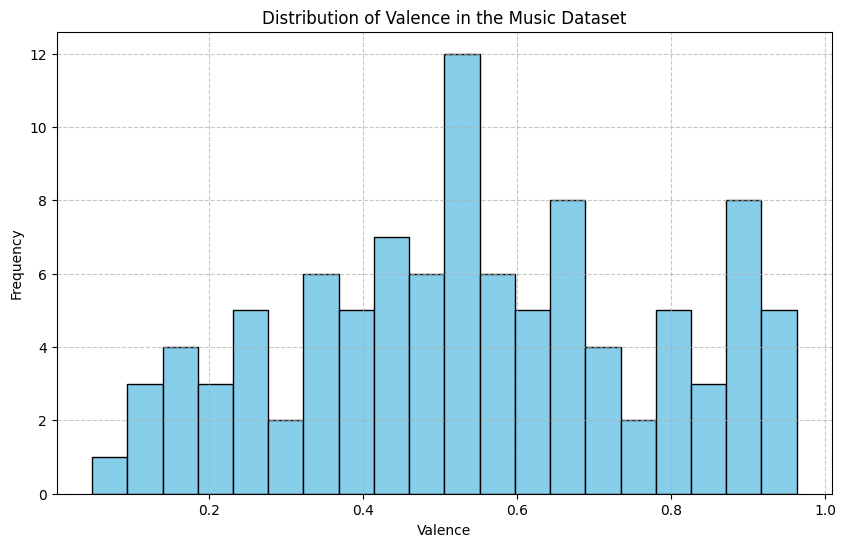

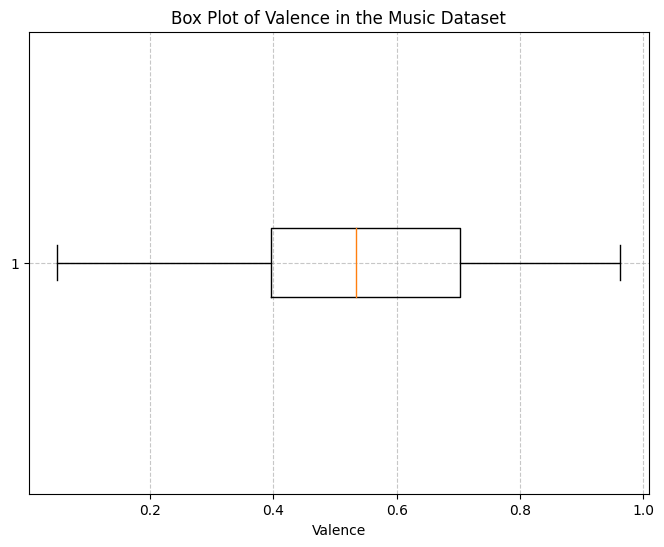

In [33]:
# Plot a histogram of the valence values
plt.figure(figsize=(10, 6))
plt.hist(music_df['Valence'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Valence in the Music Dataset')
plt.xlabel('Valence')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)

# Alternatively, you can create a box plot to visualize the spread and median of valence
plt.figure(figsize=(8, 6))
plt.boxplot(music_df['Valence'], vert=False)
plt.title('Box Plot of Valence in the Music Dataset')
plt.xlabel('Valence')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [34]:
!pip install scikit-learn

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

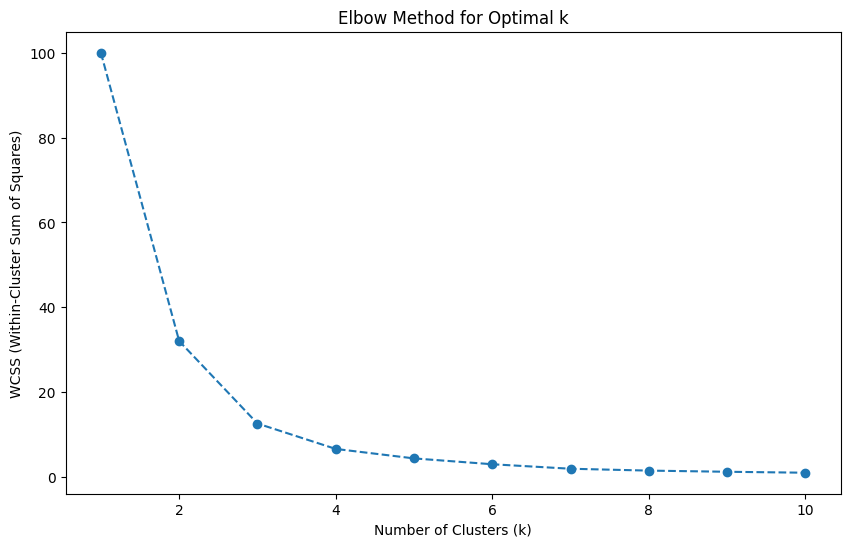

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


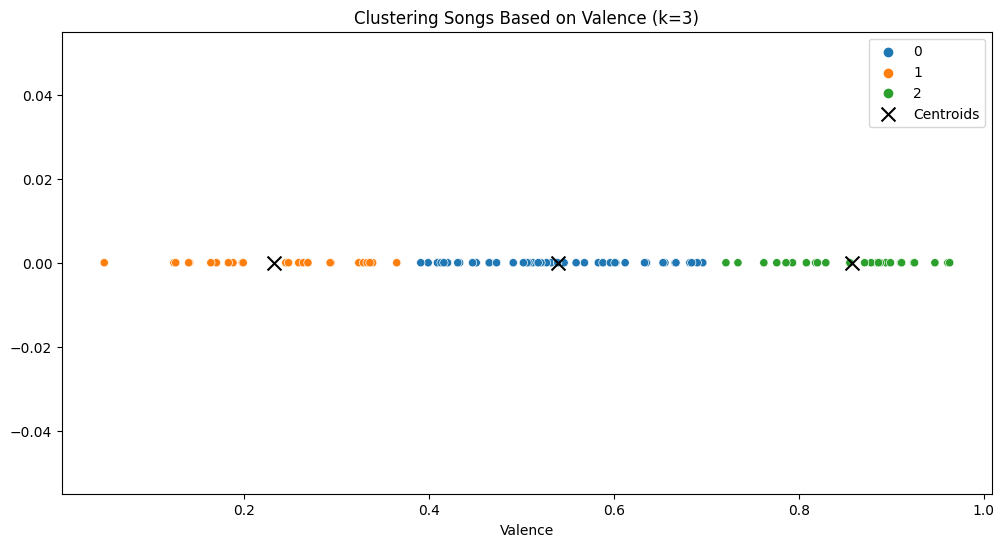

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming you have a DataFrame called 'music_df' with a 'Valence' column

# Prepare the data and standardize it
data = music_df[['Valence']].values
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Create an elbow plot to determine the optimal k value
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

# Based on the elbow plot, choose the optimal k value, let's say k=3
optimal_k = 3

# Perform clustering with the chosen k value
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(data_scaled)

# Add cluster labels to the DataFrame
music_df['Cluster'] = kmeans.labels_

# Create the cluster plot with outlines and centroids
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Valence', y=np.zeros_like(music_df['Valence']), hue='Cluster', data=music_df, palette='tab10')
plt.title(f'Clustering Songs Based on Valence (k={optimal_k})')
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers, np.zeros(optimal_k), c='black', marker='x', s=100, label='Centroids')
plt.legend()
plt.show()


In [36]:
# List songs in Cluster 0
cluster_0_songs = music_df[music_df['Cluster'] == 0]

# List songs in Cluster 1
cluster_1_songs = music_df[music_df['Cluster'] == 1]

# List songs in Cluster 2
cluster_2_songs = music_df[music_df['Cluster'] == 2]


In [41]:
print("Cluster 1 (Neutral Songs)")
print(cluster_0_songs['Track Name'])

Cluster 1 (Neutral Songs)
0                                               The Pot
1                      Eye of the Beholder (Remastered)
5                                          Who Made Who
7                                          Sad But True
12               Runnin' with the Devil - 2015 Remaster
14                      Hot for Teacher - 2015 Remaster
15                                     Talk Dirty To Me
16                                      Round and Round
17                             Smokin' In The Boys Room
18                                      Youth Gone Wild
19              Pour Some Sugar On Me - Remastered 2017
20                                  Girls, Girls, Girls
21                 Love In An Elevator - Single Version
22                               Panama - 2015 Remaster
23    It's a Long Way to the Top (If You Wanna Rock ...
24                                             Rag Doll
25                                        Sweet Emotion
26                    

In [43]:
print("Cluster 2 (Sad Songs)")
print(cluster_1_songs['Track Name'])

Cluster 2 (Sad Songs)
2                             Thunderstruck
4                         Land of Confusion
6                   No Remorse (Remastered)
10                         Live And Let Die
32                               Holy Diver
39                               Cumbersome
48                             Feel So Numb
50                               Young Lust
51                           Generation Day
55                              Bad Company
57           The Four Horsemen (Remastered)
59                              Stupid Girl
60              Bron-Y-Aur Stomp - Remaster
61                    Whiplash (Remastered)
62                         Comfortable Liar
63                                Nightrain
65        Black Wedding (feat. Rob Halford)
69                                     Torn
74                                   Opiate
76                    Welcome To The Jungle
84                             Right In Two
91    Walking On The Moon - Remastered 2003
97        

In [44]:
print("Cluster 3 (Positive Songs)")
print(cluster_2_songs['Track Name'])

Cluster 3 (Positive Songs)
3                                         I Wish
8                                    The New Day
9                                           Pink
11                      Dude (Looks Like A Lady)
13                            Back In the Saddle
27                          Carry on Wayward Son
29               Walk This Way (feat. Aerosmith)
33                            Original Prankster
35               The Other Side - Single Version
38                        Groove Is in the Heart
41                                    Turn It Up
43                                   Jump Around
49                                   Miles to Go
53           Trampled Under Foot - 1990 Remaster
64                                Possum Kingdom
66        Falling In Love (Is Hard On The Knees)
70                     Ramble On - 1990 Remaster
71                       Dancing Days - Remaster
72                    Tweeter And The Monkey Man
73                         My Best Friend'

Cluster
0    0.539824
1    0.232487
2    0.857720
Name: Valence, dtype: float64
